<strong> Import all libraires that will be used </strong>

In [1]:
from utils import ImageDataset, generate_CutMix_samples, loss_decoder, loss_encoder, loss_regularization
from models import Unet_Discriminator, Unet_Generator
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os

<strong> Initializing the paintings dataset </strong>

In [ ]:
# Building the dataset
image_dir = '../data/anime/images_2'
image_size = 64
f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
training_dataset = ImageDataset(image_dir, transform, limit=10000)
print(f"Dataset contains {len(training_dataset)} images")

44838_2014.jpg
True


NameError: name 'PaintingsDataset' is not defined

<strong> Sampling an element from the dataset and plotting it </strong>

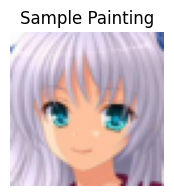

In [3]:
# Sampling randomly an element from the dataset
n = len(training_dataset)
integer = random.randint(0,n)

# Sampled image
image = training_dataset[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

<strong> Initializing the parameters of the model </strong>

In [4]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G_unet = Unet_Generator(latent_dim, channels_out, num_upsamples=4)
D_unet = Unet_Discriminator(3, 2)

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


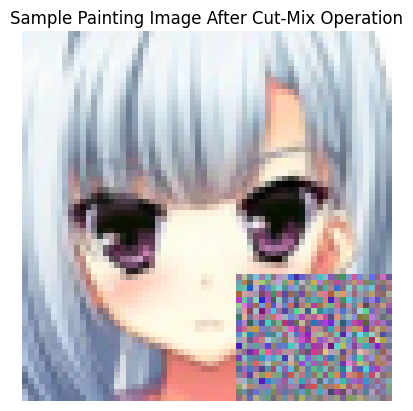

In [5]:
# Selecting randomly a sample from the dataset to plot the examples
G_unet
integer = random.randint(0, n)
image = training_dataset[integer]

# Generate random noise
noise = torch.randn(63, latent_dim, 64, 64)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)[0].unsqueeze(0) # Batch of 16 fake images
print(fake_images.shape)

# Generating another example from the dataset
integer = random.randint(0,n)
real_image = training_dataset[integer]

# Unsqueezing to match the shape of input
real_image = real_image.unsqueeze(0)
print(real_image.shape)

# Generating the cutmix image
ratio, cutmixed, cutmixed_decoded, target_a, target_b, bbx1, bbx2, bby1, bby2 = generate_CutMix_samples(real_image, fake_images, D_unet, device=torch.device('cpu'))

# Preprocessing to de-normalize
cut_mixed = cutmixed.squeeze(0).detach().numpy()*0.5 +0.5
image = fake_images.squeeze(0).detach().numpy()*0.5 +0.5

# Plot the image
plt.imshow(np.transpose(cut_mixed, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting Image After Cut-Mix Operation')
plt.show()

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

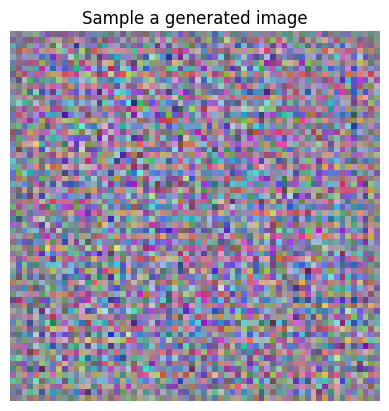

In [6]:
# Generate random noise
noise = torch.randn(64, latent_dim, 64, 64)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# De-normalizing the image
image_generated = fake_images[0].detach().numpy().reshape((3,64,64))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a generated image')
plt.show()

<strong> Let build the training loop</strong>

In [ ]:
torch.autograd.set_detect_anomaly(True)

default_batch_size = 64
dataloader = DataLoader(training_dataset, batch_size=default_batch_size)

loss_options = ["w","bce"]
loss_option = loss_options[1]

experiment = 4

output_dir = f"training_samples/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)


# Parameters
input_channels = 3
channels_out = input_channels
n_classes = 2
k = 5  # number of discriminator updates per generator update
epochs =  1000
latent_dim = 128  # Dimension of the latent space
lambda_gp = 1  # Gradient penalty weight
lambda_div = 5  # Diversity loss weight
p_mix = 0 # Probability of generating the cutmix images
steps_mix = 60
p_max = 0.5


d_lr = 1e-4 if loss_option == "w" else 2e-4  # Base learning rate
g_lr = 2e-4 if loss_option == "w" else 2e-4  # Base learning rate


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Initialize models
G_unet = Unet_Generator(latent_dim, channels_out, num_upsamples=4).to(device)  
D_unet = Unet_Discriminator(input_channels, n_classes=n_classes).to(device)
# G_unet = AttentionUNetGenerator(latent_dim, channels_out).to(device)
# D_unet = AttentionUNetDiscriminator(input_channels).to(device)

# Loss function and optimizers
criterion_encoder = loss_encoder
criterion_decoder = loss_decoder
criterion_regular = loss_regularization


# criterion = torch.nn.BCELoss()
optimizer_g = torch.optim.Adam(G_unet.parameters(), lr=g_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
optimizer_d = torch.optim.Adam(D_unet.parameters(), lr=d_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=epochs)
scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_d, T_max=epochs)

# FID Evaluation setup
epoch_fid = epochs // 20  # Evaluate FID every `epoch_eval` epochs
epoch_sampling = 10 # Save generated samples every `epoch_sampling` epochs

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500


# Ensure your dataset of real paintings is available
N = len(training_dataset)  # Assuming `paintings` is a tensor of real images
indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([training_dataset[idx] for idx in indices])
fid.update(real_images_eval, real=True)


# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []

for epoch in tqdm(range(1, epochs+1)):
    start_time = time.time()
    iter_count = 0
    cutmix_count = 0

    # Turn dataloader into an iterator for this epoch
    data_iter = iter(dataloader)
    ################################################################
    # 1) DISCRIMINATOR UPDATES — do k iterations
    ################################################################  
    while True:
        for _ in range(k):
            try:
                # Get next batch of real images
                real_images = next(data_iter).to(device)
            except StopIteration:
                # If we've exhausted the dataloader, end this epoch
                break
            
            # Labels for real and fake images
            batch_size = real_images.size(0)
            # W, H = real_images.size(1), real_images.size(2)
            
            labels_real = torch.full((batch_size, 1), 0.9, device=device)
            labels_fake = torch.full((batch_size, 1), 0.1, device=device)
            
            labels_real_pixel = torch.full((batch_size, 1, 64, 64), 0.9, device=device)
            labels_fake_pixel = torch.full((batch_size, 1, 64, 64), 0.1, device=device)
            

            # Train discriminator with real images
            optimizer_d.zero_grad()

            # Optionally add small noise to real images
            real_noisy = real_images + torch.randn_like(real_images) * 0.01

            output_real = D_unet(real_noisy)
            output_1_real = output_real[0]
            output_2_real = output_real[1]
            
            loss_d_real_encoder = criterion_encoder(output_1_real, labels_real)
            loss_d_real_decoder = criterion_decoder(output_2_real, labels_real_pixel)
            # loss_d_real = criterion(output_real, labels_real, batch_size=batch_size)

            # Train discriminator with fake images
            noise = torch.randn(batch_size, latent_dim, 64, 64, device=device)
            fake_images = G_unet(noise).detach() # detach so G is not updated here
            
            fake_noisy = fake_images + torch.randn_like(fake_images) * 0.01

            # Forward pass of the fake images through the U-Net-based discriminator
            output_fake = D_unet(fake_noisy)  # Detach fake images to avoid affecting the generator during backprop
            output_1_fake = output_fake[0]  # First part of the output (for encoder loss)
            output_2_fake = output_fake[1]  # Second part of the output (for decoder loss)

                        # Calculate the loss for the fake images for both encoder and decoder outputs
            loss_d_fake_encoder = criterion_encoder(output_1_fake, labels_fake)  # Loss for encoder using fake images
            loss_d_fake_decoder = criterion_decoder(output_2_fake, labels_fake_pixel)  # Loss for decoder using fake pixel labels
            
            alpha = torch.rand(batch_size, 1, 1, 1, device=device)
            d_interpolates = alpha * real_images + (1 - alpha) * fake_images
            d_interpolates.requires_grad = True
            d_out = D_unet(d_interpolates)[0]
            gradients = torch.autograd.grad(outputs=d_out, inputs=d_interpolates,
                                            grad_outputs=torch.ones_like(d_out, device=device),
                                            create_graph=True, retain_graph=True, only_inputs=True)[0]
            gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

            # Total loss for discriminator combining real and fake image losses
            loss_d = loss_d_real_encoder + loss_d_fake_encoder + loss_d_real_decoder + loss_d_fake_decoder + gradient_penalty
            
            # Apply CutMix augmentation with a probability of p_mix
            if random.random() < p_mix:
                # Generate CutMix samples by mixing real and fake images
                ratio, cutmix_images, cutmix_decoded, target_a, target_b, bbx1, bbx2, bby1, bby2 = generate_CutMix_samples(real_images, fake_images, D_unet, device)
                
                labels_cutmix = torch.full((batch_size, 1), 0.9, device=device)
                labels_cutmix_pixel = torch.full((batch_size, 1, 64, 64), 0.9, device=device)
                
                for x1, x2, y1, y2 in zip(bbx1, bbx2, bby1, bby2):
                    labels_cutmix_pixel[:,:,x1:x2, y1:y2] = 0.1  # Set labels to 0.1 inside the bounding box for the mixed area
                    
                    
                    
                # Forward pass of the CutMix images through the U-Net-based discriminator
                output_cutmix = D_unet(cutmix_images)  # Detach to avoid affecting generator during backprop
                output_1_cutmix = output_cutmix[0]  # First part of the output (for encoder loss)
                output_2_cutmix = output_cutmix[1]  # Second part of the output (for decoder loss)

                # Calculate the loss for the CutMix images for encoder, decoder, and regularization
                loss_d_encoder_cutmix = criterion_encoder(output_1_cutmix, labels_cutmix)  # Encoder loss with CutMix images
                loss_d_decoder_cutmix = criterion_decoder(output_2_cutmix, labels_cutmix_pixel)  # Decoder loss with pixel labels
                
                loss_d_cutmix_regular = criterion_regular(output_2_cutmix, cutmix_decoded)  # Regularization loss for the decoded mixed region

                # Add CutMix losses to the total discriminator loss
                loss_d += loss_d_encoder_cutmix + loss_d_decoder_cutmix + loss_d_cutmix_regular
                
            
            loss_d.backward()
            optimizer_d.step()
            
            D_loss.append(loss_d.item())

        else:
            ################################################################
            # 2) GENERATOR UPDATE — 1 iteration
            ################################################################
            for p in D_unet.parameters():
                p.requires_grad = False
                
            labels_real = torch.full((default_batch_size, 1), 0.9, device=device)
            labels_real_pixel = torch.full((default_batch_size, 1, 64, 64), 0.9, device=device)
            
            noise = torch.randn(default_batch_size, latent_dim, 64, 64, device=device)
            fake_images = G_unet(noise)

            optimizer_g.zero_grad()

            output_1, output_2 = D_unet(fake_images)
            loss_g_encoder = criterion_encoder(output_1, labels_real)  # Generator encoder loss (fake -> real)
            loss_g_decoder = criterion_decoder(output_2, labels_real_pixel)  # Generator decoder loss (fake -> real pixels)


            loss_g = loss_g_decoder + loss_g_encoder
            G_loss.append(loss_g.item())

            # Backpropagate the generator loss and update generator's parameters
            loss_g.backward()  # Calculate gradients for the generator
            optimizer_g.step()  # Update the generator's weights

            for p in D_unet.parameters():
                p.requires_grad = True
         # Go back to the while loop for next set of k updates + 1 gen update
            continue

        # If we did break out of the for-loop (StopIteration),
        # it means we've run out of data for this epoch.
        break
    
    
     # Evaluate FID every `epoch_eval` epochs
    if epoch % epoch_fid == 0:
        G_unet.eval()  # Set generator to eval mode for FID computation
        fake_images_eval = []
        with torch.no_grad():
        # Generate evaluation images
            noise_eval = torch.randn(n_samples, latent_dim, 64, 64, device=device)
            for i in range(0, n_samples, batch_size):
                fake_images_chunk = G_unet(noise_eval[i:i+batch_size]).to('cpu')
                fid.update(fake_images_chunk, real=False)
                fake_images_eval.append(fake_images_chunk)

            fid_value = fid.compute().item()
            FID_values.append(fid_value)

            print(f'FID after epoch {epoch}: {fid_value}')

        # Save a grid of generated samples
        fake_images_eval = torch.cat(fake_images_eval, dim=0)
        grid = vutils.make_grid(fake_images_eval[:64], normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        fid.reset()
        G_unet.train()
        
    if epoch % epoch_sampling == 0:
        G_unet.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        with torch.no_grad():
            noise_eval = torch.randn(64, latent_dim, 64, 64, device=device)
            fake_images_eval = G_unet(noise_eval).to(torch.device('cpu'))
        
        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        G_unet.train()
        
        # Track losses
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())


    end_time = time.time()
    
    # Update the probability of applying CutMix augmentation, gradually increasing to a maximum of 0.5
    scheduler_g.step()
    scheduler_d.step()
    
    print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()} | Gradient Penalty: {gradient_penalty.item()}')
    print(f'Epoch duration: {end_time - start_time:.2f}s')
    

cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000] | Loss D: 2.3915843963623047 | Loss G: 4.197771072387695 | Gradient Penalty: 0.9990377426147461
Epoch duration: 85.56s
Epoch [2/1000] | Loss D: 4.443961143493652 | Loss G: 2.7498083114624023 | Gradient Penalty: 0.999147891998291
Epoch duration: 85.84s
Epoch [3/1000] | Loss D: 3.1401658058166504 | Loss G: 1.7507658004760742 | Gradient Penalty: 0.9982296228408813
Epoch duration: 85.86s
Epoch [4/1000] | Loss D: 2.508953332901001 | Loss G: 3.70687198638916 | Gradient Penalty: 0.9982510805130005
Epoch duration: 69.50s
Epoch [5/1000] | Loss D: 3.707808256149292 | Loss G: 1.554292917251587 | Gradient Penalty: 0.9994785189628601
Epoch duration: 69.43s
Epoch [6/1000] | Loss D: 3.356919288635254 | Loss G: 4.159384727478027 | Gradient Penalty: 0.9980162382125854
Epoch duration: 69.74s
Epoch [7/1000] | Loss D: 3.371262788772583 | Loss G: 1.6093000173568726 | Gradient Penalty: 0.9989259243011475
Epoch duration: 70.65s
Epoch [8/1000] | Loss D: 3.5399763584136963 | Loss G: 1.6408885717

In [28]:
torch.save(D_unet.state_dict(), "models/d_unet.pth")
torch.save(G_unet.state_dict(), "models/g_unet.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 128, 128])


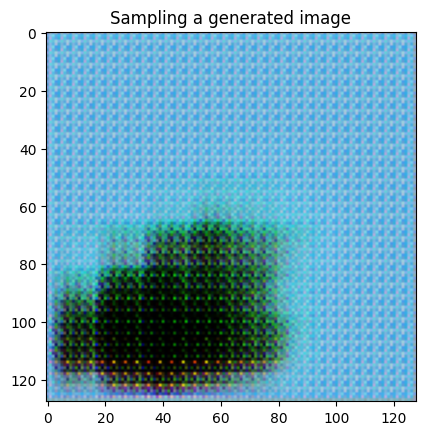

In [32]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,64,64))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

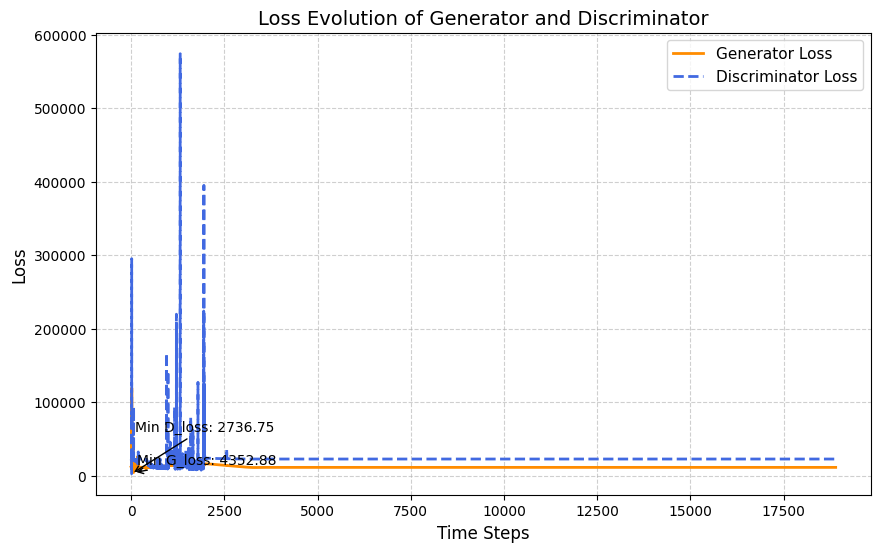

In [30]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

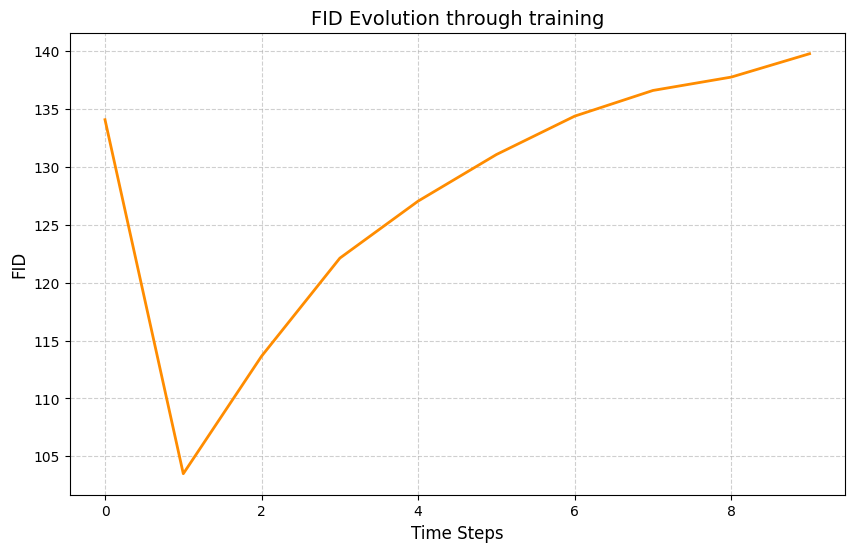

In [31]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)